<a href="https://colab.research.google.com/github/MicroprocessorX069/Stroke-Prediction-/blob/master/WideAndDeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
# from classes3 import  FeedForwardNN
import torch.nn as nn
import torch.nn.functional as F
import os
from datetime import datetime
# import visdom

In [2]:
path="/content/drive/My Drive/Projects/StrokePrediction/data/healthcare-dataset-stroke-data"
data= pd.read_csv(os.path.join(path,"train_2v.csv")).dropna()
data.shape

(29072, 12)

In [3]:
data['Weights'] = np.where(data['stroke'] == 1, 0.9, .004)
data['Weights'].unique()

val_data=data.sample(frac=0.05, random_state=123, weights='Weights')
#train_data = data.loc[~data.index.isin(val_data.index)]
print(len(np.where(val_data['stroke']==1)[0]),len(np.where(val_data['stroke']==0)[0]))
data_org=data

548 906


In [0]:
# test_path="/content/drive/My Drive/Projects/StrokePrediction/data/healthcare-dataset-stroke-data"
# test_data= pd.read_csv(os.path.join(path,"test.csv")).dropna()
# test_data.shape

In [0]:
from torch.utils.data import Dataset, DataLoader


class TabularDataset2(Dataset):
  def __init__(self, data, cat_cols=None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """

    self.n = data.shape[0]

    if output_col:
      self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
    else:
      self.y =  np.zeros((self.n, 1))

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in data.columns
                      if col not in self.cat_cols + [output_col]]

    if self.cont_cols:
      self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = data[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n

  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]
  

  
  
class FeedForwardNN(nn.Module):
  def __init__(self,emb_dims,no_of_cont, lin_layer_sizes,
              output_size,emb_dropout, lin_layer_dropouts):
    '''
    #emb_dims: list of two tuples
    #tuple1: no. of unqie values for that categorical variable
    #tuple 2: shape of that features data
    
    #no_of_cont: number of continuous features
    
    lin_layer_sizes: list of integers
    no. of nodes in each linear layer in the network
    
    output_size=Integer
    size of final output
    
    emb_dropout: float
    dropout used after embedding layers
    
    lin_layer_dropouts: 
    dropout after each linear layer
    
    '''
    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])

    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])

    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    for lin_layer in self.lin_layers:
      nn.init.kaiming_normal_(lin_layer.weight.data)

    # Output Layer
    self.output_layer = nn.Sequential(nn.Linear(30,
                                  output_size),nn.Sigmoid())
    #nn.init.kaiming_normal_(self.output_layer.weight.data)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self,cont_data,cat_data):
    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)
      

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
        y=x
      else:
        x = normalized_cont_data
        y=x
        
    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.droput_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)
    
    x=torch.cat([x,y],1)
    #print(x.size(),y.size())
    x = self.output_layer(x)
    
    return x
  
  
def weighted_binary_cross_entropy(output, target, weights=None):
    output = torch.clamp(output,min=1e-8,max=1-1e-8)  
    if weights is not None:
        
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))


##Analysis

In [0]:
data.stroke.value_counts()


0    28524
1      548
Name: stroke, dtype: int64

##Features segregation

In [0]:
categorical_features=["gender","hypertension","heart_disease",
                      "ever_married","work_type","Residence_type",
                     "smoking_status"]
output_feature="stroke"

from sklearn.preprocessing import LabelEncoder
label_encoders={}
for cat_col in categorical_features:
  label_encoders[cat_col]=LabelEncoder()
  data[cat_col]=label_encoders[cat_col].fit_transform(data[cat_col])


In [0]:
data=data.drop("Weights",axis=1)
data_org=data
data=data.drop("id",axis=1)

##Creating object of class 'Tabular Dataset'

In [7]:
dataset=TabularDataset2(data=data,cat_cols=categorical_features,
                      output_col=output_feature)
dataset[0]

[array([0.], dtype=float32),
 array([58.  , 87.96, 39.2 ], dtype=float32),
 array([1, 1, 0, 1, 2, 1, 1])]

##Parameters

In [0]:
batchsize=800
dataloader=DataLoader(dataset,batchsize,shuffle=True,num_workers=1)

##Getting the dimensions for embeddings

In [9]:
cat_dims=[int(data[col].nunique()) for col in categorical_features] #no of unique values for each categorical variable
emb_dims=[(x,min(128,(x+1)//2)) for x in cat_dims] #reducing the embedding to half size.
emb_dims

[(3, 2), (2, 1), (2, 1), (2, 1), (5, 3), (2, 1), (3, 2)]

##Creating an instance of model

In [0]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Hyper parameters
no_of_cont=3 #no of continuous variables 
lin_layer_sizes=[64,32,16]
output_size=1
emb_dropout=0.04
lin_layer_dropouts=[0.001,0.01,0.01]
model= FeedForwardNN(emb_dims, no_of_cont, lin_layer_sizes,
                    output_size, emb_dropout,
                    lin_layer_dropouts).to(device)

##Training

In [17]:
# vis = Visualizations()

no_of_epochs = 5000
# criterion = nn.BCEWithLogitsLoss()
# criterion=nn.MSELoss()
criterion=nn.BCELoss()
class_weights=[0.5,1.2]
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
flag=False
loss_values = []
for epoch in range(no_of_epochs):
      i=0
      
      for y, cont_x, cat_x in dataloader:
        i+=1
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y  = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
        if(torch.isnan(preds[0])):
          print("Oh no")
          flag=True
          break
        
        #loss = criterion(preds, y)
        loss=weighted_binary_cross_entropy(preds,y)
        
        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        if(i==1):
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, no_of_epochs, i+1, batchsize, loss.item()))
          
      if flag:
        break
      loss_values.append(loss)
      
      


Epoch [1/5000], Step [2/800], Loss: 0.4821
Epoch [2/5000], Step [2/800], Loss: 0.0895
Epoch [3/5000], Step [2/800], Loss: 0.0957
Epoch [4/5000], Step [2/800], Loss: 0.0755
Epoch [5/5000], Step [2/800], Loss: 0.0724
Epoch [6/5000], Step [2/800], Loss: 0.0696
Epoch [7/5000], Step [2/800], Loss: 0.0744
Epoch [8/5000], Step [2/800], Loss: 0.1089
Epoch [9/5000], Step [2/800], Loss: 0.0964
Epoch [10/5000], Step [2/800], Loss: 0.0863
Epoch [11/5000], Step [2/800], Loss: 0.0740
Epoch [12/5000], Step [2/800], Loss: 0.0634
Epoch [13/5000], Step [2/800], Loss: 0.0833
Epoch [14/5000], Step [2/800], Loss: 0.0814
Epoch [15/5000], Step [2/800], Loss: 0.0764
Epoch [16/5000], Step [2/800], Loss: 0.0576
Epoch [17/5000], Step [2/800], Loss: 0.1041
Epoch [18/5000], Step [2/800], Loss: 0.0878
Epoch [19/5000], Step [2/800], Loss: 0.0668
Epoch [20/5000], Step [2/800], Loss: 0.0645
Epoch [21/5000], Step [2/800], Loss: 0.0697
Epoch [22/5000], Step [2/800], Loss: 0.0772
Epoch [23/5000], Step [2/800], Loss: 0.04

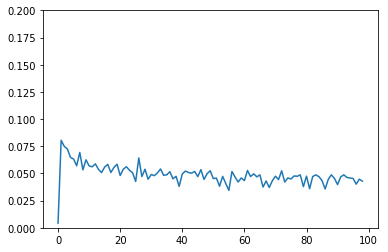

In [20]:
import matplotlib.pyplot as plt

temp=0
batch=20
avg_loss_values=[]
for i,loss in enumerate(loss_values):
  temp+=loss
  if i%batch==0:
    avg_loss_values.append(temp/batch)
    temp=0
   
plt.plot(avg_loss_values)
plt.ylim((0,0.2))
plt.show()    

In [0]:
model.modules

##Setting up Test Loader

In [0]:

label_encoders={}
for cat_col in categorical_features:
  label_encoders[cat_col]=LabelEncoder()
  val_data[cat_col]=label_encoders[cat_col].fit_transform(val_data[cat_col])
  
val_data=val_data.drop("Weights",axis=1)
val_data_org=val_data
val_data=val_data.drop("id",axis=1)

val_dataset=TabularDataset2(data=val_data,cat_cols=categorical_features,
                      output_col=output_feature)
val_dataset[0]



[array([0.], dtype=float32),
 array([41.  , 62.17, 41.2 ], dtype=float32),
 array([0, 0, 0, 1, 3, 0, 1])]

In [0]:
batchsize=1454
val_dataloader=DataLoader(val_dataset,batchsize,shuffle=False)


In [0]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
prec_values,rec_values,f1_values=[],[],[]

with torch.no_grad():
  loss,i=0,0
  
  for y, cont_x, cat_x in val_dataloader:
    cat_x = cat_x.to(device)
    cont_x = cont_x.to(device)
    y  = y.to(device)
    preds=model(cont_x, cat_x)
    #preds=torch.round(preds)
#     print(y[:5])
    #loss+=criterion(preds,y)
    loss=weighted_binary_cross_entropy(preds,y)
    i+=1
    precision,recall,fscore,_=precision_recall_fscore_support(y, torch.round(preds), average='macro')
    prec_values.append(precision)
    rec_values.append(recall)
    f1_values.append(fscore)
    
    
    
    
    
  print('Loss of the model: {} '.format( loss / i))
torch.save(model.state_dict(),'model.ckpt')

Loss of the model: 1.387656331062317 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
!pip install scikit-plot

In [0]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import scikitplot as skplt
# y_true = np.array(['cat', 'dog', 'pig', 'cat', 'dog', 'pig'])
# y_pred = np.array(['cat', 'pig', 'dog', 'cat', 'cat', 'dog'])

# print (y)
# print (preds)

y_true = y.tolist()
y_pred = torch.round(preds).tolist()
print (precision_recall_fscore_support(y_true, y_pred, average='macro'))

print (accuracy_score(y_true, y_pred))
print (accuracy_score(y_true, y_pred, normalize=False))

#skplt.metrics.plot_roc_curve(y_true, y_pred)
plt.show()

(0.3115543328748281, 0.5, 0.3838983050847458, None)
0.6231086657496562
906


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


IndexError: ignored

In [0]:
print (len(rec_values))

30


In [0]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_true, y_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.38


In [0]:
# print(prec_values)
# print(rec_values)
# #plt.plot(rec_values,prec_values)

[0.09, 0.5714285714285714, 0.59375, 0.5918367346938775, 0.12, 0.625, 0.6666666666666666, 0.71875, 0.12, 0.7551020408163265, 0.7083333333333334, 0.6979166666666666, 0.7551020408163265, 0.33, 0.32, 0.8367346938775511, 0.8775510204081632, 0.39, 0.9693877551020409, 0.44, 0.48, 0.46, 0.9897959183673469, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, 0.5]
[0.5, 0.5116279069767442, 0.524390243902439, 0.5121951219512195, 0.5, 0.5263157894736842, 0.5294117647058824, 0.5344827586206896, 0.5, 0.52, 0.5333333333333333, 0.532258064516129, 0.52, 0.5, 0.5, 0.5294117647058824, 0.5384615384615384, 0.5, 0.625, 0.5, 0.5, 0.5, 0.75, 1.0, 0.49, 1.0, 1.0, 0.48, 1.0, 0.375]


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.38')

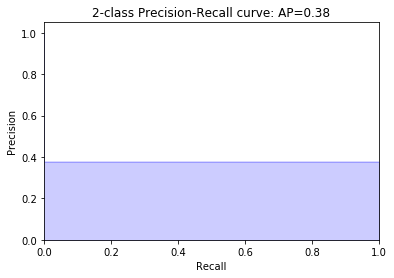

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall = prec_values, rec_values

precision, recall, _ = precision_recall_curve(y_true, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))